In [26]:
# This serves as a template which will guide you through the implementation of this task.  It is advised
# to first read the whole template and get a sense of the overall structure of the code before trying to fill in any of the TODO gaps
# First, we import necessary libraries:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox, yeojohnson
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, RBF, Matern, RationalQuadratic
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score



In [27]:
train_df = pd.read_csv("train.csv")

print("Training data:")
print("Shape:", train_df.shape)
print(train_df.head(2))
print('\n')

# Load test data
test_df = pd.read_csv("test.csv")

print("Test data:")
print(test_df.shape)
print(test_df.head(2))

# Dummy initialization of the X_train, X_test and y_train   
X_train = np.zeros_like(train_df.drop(['price_CHF'],axis=1))
y_train = np.zeros_like(train_df['price_CHF'])
X_test = np.zeros_like(test_df)

Training data:
Shape: (900, 11)
   season  price_AUS  price_CHF  price_CZE  price_GER  price_ESP  price_FRA  \
0  spring        NaN   9.644028  -1.686248  -1.748076  -3.666005        NaN   
1  summer        NaN   7.246061  -2.132377  -2.054363  -3.295697  -4.104759   

   price_UK  price_ITA  price_POL  price_SVK  
0 -1.822720  -3.931031        NaN  -3.238197  
1 -1.826021        NaN        NaN  -3.212894  


Test data:
(100, 10)
   season  price_AUS  price_CZE  price_GER  price_ESP  price_FRA  price_UK  \
0  spring        NaN   0.472985   0.707957        NaN  -1.136441 -0.596703   
1  summer  -1.184837   0.358019        NaN  -3.199028  -1.069695       NaN   

   price_ITA  price_POL  price_SVK  
0        NaN   3.298693   1.921886  
1  -1.420091   3.238307        NaN  


In [ ]:
train_df.describe()

,price_AUS,price_CHF,price_CZE,price_GER,price_ESP,price_FRA,price_UK,price_ITA,price_POL,price_SVK
count,638.000000,631.000000,632.000000,631.000000,631.000000,636.000000,613.000000,634.000000,635.000000,619.000000
mean,-0.665411,4.538611,-0.221514,-0.421923,-4.737647,-2.914028,-1.518137,-2.686282,-0.296811,-0.643735
std,1.016447,3.328953,1.192286,1.155131,1.186441,1.102510,1.613119,1.150795,2.012512,2.093138
min,-2.362783,-3.736940,-2.147384,-2.238546,-6.891480,-4.428215,-3.940520,-4.330588,-2.912800,-3.499810
25%,-1.613550,2.640888,-1.522282,-1.633691,-5.688912,-3.884357,-2.643156,-3.737076,-2.354075,-2.923394
50%,-0.577244,3.872916,0.198743,-0.251429,-4.514822,-3.291359,-1.863632,-2.881648,-0.420106,-0.443855
75%,0.005234,7.736682,0.784038,0.646908,-3.603188,-2.025672,-0.270304,-1.817957,1.605009,1.536044
max,1.316798,9.933313,1.710173,1.659539,-2.858268,0.000619,1.624482,0.943226,3.421927,2.527192


# Pre-processing of the data
1. Filter out zero or near-zero variance features.
2. Perform imputation if required.
3. Normalize to resolve numeric feature skewness.
4. Standardize (center and scale) numeric features.
5. Perform dimension reduction (e.g., PCA) on numeric features.
6. One-hot or dummy encode categorical features.
7. VIF test
8. Feature selection 

In [46]:
# 1. feature variances
feature_variances = train_df.var()

threshold_variance = 0.3 # this value could be varied depending if we want 
selected_features = feature_variances[feature_variances > threshold_variance].index

train_df_filtered = train_df[selected_features].join(train_df["season"])

train_df_filtered = train_df_filtered.dropna(subset=['price_CHF'])


<ipython-input-46-45f6b3ad9549>:2: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  feature_variances = train_df.var()


In [29]:
# 2. Missingness per feature
missing_values_per_season = train_df_filtered.groupby("season").apply(lambda x: (x.isna().sum()))
print("Number of missing values:")
print(missing_values_per_season)
print("\n")

missing_values_per_season_perct = train_df_filtered.groupby("season").apply(lambda x: 100*((x.isna().sum())/len(x)))
print("Percentage of missingness:")
print(missing_values_per_season_perct)

# Conclusion > similar percentage of missing values per seaosn and per country (feature), with very high values (~30%)

Number of missing values:
        price_AUS  price_CHF  price_CZE  price_GER  price_ESP  price_FRA  \
season                                                                     
autumn         58          0         56         55         57         52   
spring         52          0         54         54         56         55   
summer         42          0         43         53         52         45   
winter         52          0         49         61         54         55   

        price_UK  price_ITA  price_POL  price_SVK  season  
season                                                     
autumn        48         55         46         56       0  
spring        63         58         52         51       0  
summer        58         56         48         56       0  
winter        51         38         47         55       0  


Percentage of missingness:
        price_AUS  price_CHF  price_CZE  price_GER  price_ESP  price_FRA  \
season                                              

In [30]:
# Define two functions to input missing values
def impute_avg_per_season(df, season_col="season"):
    return df.groupby(season_col).transform(lambda x: x.fillna(x.median())).join(df[season_col])

In [80]:
def linear_regression_imputation(df, features_to_impute):
    # Create a copy of the data frame to avoid modifying the original data frame
    dfc = df.copy()

    # One-hot encode categorical variables
    dfc = pd.get_dummies(dfc, columns=['season'], prefix=['season'])

    for feature in features_to_impute:
        # Filter data with and without missing values
        data_with_feature = dfc[dfc[feature].notnull()]
        data_missing_feature = dfc[dfc[feature].isnull()]

        # Create X and y for the feature
        X = data_with_feature.drop(features_to_impute, axis='columns').values
        y = data_with_feature[feature].values

        # Train and predict using KFold cross-validation
        np.random.seed(42)
        kf = KFold(n_splits=4)
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            clf = LinearRegression()
            clf.fit(X_train, y_train)
            y_test_pred = clf.predict(X_test)

        # Impute missing values
        X_missing = data_missing_feature.drop(features_to_impute, axis='columns').values
        y_missing_pred = clf.predict(X_missing)
        dfc.loc[dfc[feature].isnull(), feature] = y_missing_pred

    return dfc

In [81]:
train_df_avg_imputed = impute_avg_per_season(train_df_filtered)

target_features = [col for col in train_df_filtered.columns if col not in ['price_CHF', 'season']]
train_df_linear_imputed = linear_regression_imputation(train_df_filtered, target_features)


In [8]:
def plot_density_train_df(df, feature_names):

  imputed_values = df[feature_names].stack().reset_index().rename(columns={'level_1': 'feature', 0: 'imputed_value'})

  fig, axes = plt.subplots(3, 3, figsize=(15, 15))
  axes = axes.flatten()

  for idx, feature in enumerate(feature_names):
      ax = axes[idx]
      sns.kdeplot(
          data=imputed_values[imputed_values['feature'] == feature],
          x='imputed_value',
          ax=ax
      )
      ax.set_title(feature)

  plt.tight_layout()
  plt.show()

In [82]:
# 3. Resolve skewness of the data and transform the features
# As our features are distributed following multimodal Gaussian densities, a Box Cox transformation can be a good option

box_cox_constant = 10 # box-cox works only with strictly positive features, so the features need to be shifted

#train_df_boxcox = train_df_linear_imputed.copy()
train_df_boxcox = train_df_avg_imputed.copy()

feature_names = [col for col in train_df_boxcox.columns if col not in ['season', 'price_CHF']]

for feature in feature_names:
    # Shift data to ensure postivity
    shifted_data = train_df_boxcox[feature] - train_df_boxcox[feature].min() + box_cox_constant
    
    # Apply boxcox
    train_df_boxcox[feature], _ = boxcox(shifted_data)

    train_df_boxcox[feature], _ = yeojohnson(train_df_boxcox[feature])


In [83]:
# 4. Standarize numeric variables
scaler = StandardScaler()

# Normalize transformed features
train_df_normalized = train_df_boxcox.copy()
train_df_normalized[feature_names] = scaler.fit_transform(train_df_boxcox[[f'{feature}' for feature in feature_names]])

#plot_density_train_df(train_df_normalized, feature_names)

In [85]:
# 6. Dummy encode categorical variables
categorical_features = ['season']
train_df_encoded = pd.get_dummies(train_df_normalized, columns=categorical_features)


In [86]:
# 8. Explore collinearity and VIF test
# Calculate VIF for each feature
vif = pd.DataFrame()
vif['feature'] = feature_names
vif['VIF'] = [variance_inflation_factor(train_df_encoded[feature_names].values, i) for i in range(len(feature_names))]

# Display the VIF values
print(vif)

     feature       VIF
0  price_AUS  1.997982
1  price_CZE  2.063472
2  price_GER  1.983902
3  price_ESP  1.399802
4  price_FRA  2.124913
5   price_UK  1.124656
6  price_ITA  2.137909
7  price_POL  2.152119
8  price_SVK  2.028711


In [87]:
grouped = train_df_normalized.groupby('season')

# Define a function to calculate and display the correlation coefficients
def compute_correlations(df, target_col):
    correlations = df.corr()[target_col].drop(target_col)
    return correlations

# Calculate and display the correlation coefficients for each group
for season, group in grouped:
    print(f"Correlation coefficients for season {season}:")
    correlations = compute_correlations(group, 'price_CHF')
    #print(correlations)
    print("\nSorted by absolute value:")
    print(correlations.abs().sort_values(ascending=False))
    print("\n" + "-"*50 + "\n")

Correlation coefficients for season autumn:

Sorted by absolute value:
price_POL    0.758890
price_SVK    0.756647
price_ITA    0.726519
price_GER    0.722574
price_CZE    0.712304
price_FRA    0.706486
price_AUS    0.603056
price_ESP    0.381917
price_UK     0.186116
Name: price_CHF, dtype: float64

--------------------------------------------------

Correlation coefficients for season spring:

Sorted by absolute value:
price_GER    0.748272
price_POL    0.745840
price_ITA    0.741884
price_SVK    0.741720
price_FRA    0.737549
price_CZE    0.663744
price_AUS    0.563538
price_ESP    0.422837
price_UK     0.199794
Name: price_CHF, dtype: float64

--------------------------------------------------

Correlation coefficients for season summer:

Sorted by absolute value:
price_POL    0.805843
price_FRA    0.748115
price_SVK    0.718858
price_ITA    0.706648
price_GER    0.699157
price_CZE    0.683386
price_AUS    0.635492
price_ESP    0.350208
price_UK     0.173346
Name: price_CHF, dtype:

<ipython-input-87-8f4e7c09b36a>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr()[target_col].drop(target_col)
<ipython-input-87-8f4e7c09b36a>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr()[target_col].drop(target_col)
<ipython-input-87-8f4e7c09b36a>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr()[target_col].drop(target_col)
<ipython-input-87-8f4e7c09b36a>:5: FutureWarning: The default value of numer

In [88]:
X = train_df_normalized.drop(["price_CHF", "season"], axis=1)
y = train_df_normalized["price_CHF"]

# Group the dataset by the 'season' column
grouped = train_df_normalized.groupby('season')

# Create a dictionary to store the best models for each season
best_models = {}

# Iterate over each season group
for season, group in grouped:
    print(f"Fitting Gaussian Process model for season {season}:")
    
    X_group = group.drop(["price_CHF", "season"], axis=1)
    y_group = group["price_CHF"]
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_group, y_group, test_size=0.2, random_state=42)
    
    # Define kernels to test
    kernels = [
        ("DotProduct", DotProduct()),
        ("RBF", RBF()),
        ("Matern", Matern()),
        ("RationalQuadratic", RationalQuadratic()),
    ]
    
    best_score = float("-inf")
    best_kernel = None
    best_model = None
    
    # Iterate over kernels and fit the model using cross-validation
    for kernel_name, kernel in kernels:
        gpr = GaussianProcessRegressor(kernel=kernel)
        scores = cross_val_score(gpr, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
        mean_score = scores.mean()
        
        print(f"Kernel: {kernel_name}, Mean Cross-Validation MSE: {mean_score}")

        if mean_score > best_score:
            best_score = mean_score
            best_kernel = kernel_name
            best_model = gpr
    
    # Fit the best model on the whole training data
    best_model.fit(X_train, y_train)
    print(f"Best kernel for season {season}: {best_kernel}")
    
    # Store the best model for the current season in the best_models dictionary
    best_models[season] = best_model
    
    # Evaluate the model on the test set
    test_score = best_model.score(X_test, y_test)
    print(f"Test set R^2 score for season {season}: {test_score}\n")

Fitting Gaussian Process model for season autumn:
Kernel: DotProduct, Mean Cross-Validation MSE: -1.8025894467628238
Kernel: RBF, Mean Cross-Validation MSE: -1.8987556978015174
Kernel: Matern, Mean Cross-Validation MSE: -1.4006129594364218
Kernel: RationalQuadratic, Mean Cross-Validation MSE: -1.6117727652546783
Best kernel for season autumn: Matern
Test set R^2 score for season autumn: 0.8709776250471153

Fitting Gaussian Process model for season spring:


/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Kernel: DotProduct, Mean Cross-Validation MSE: -2.163158028474669
Kernel: RBF, Mean Cross-Validation MSE: -1.5244937112152317
Kernel: Matern, Mean Cross-Validation MSE: -1.1131894070612647
Kernel: RationalQuadratic, Mean Cross-Validation MSE: -1.1625988133819731
Best kernel for season spring: Matern
Test set R^2 score for season spring: 0.9223380432956537

Fitting Gaussian Process model for season summer:
Kernel: DotProduct, Mean Cross-Validation MSE: -1.5069825377816126
Kernel: RBF, Mean Cross-Validation MSE: -2.2015860923941504
Kernel: Matern, Mean Cross-Validation MSE: -1.3064455397063623
Kernel: RationalQuadratic, Mean Cross-Validation MSE: -1.4200480774698538
Best kernel for season summer: Matern
Test set R^2 score for season summer: 0.8578276661689451

Fitting Gaussian Process model for season winter:


/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Kernel: DotProduct, Mean Cross-Validation MSE: -1.3376804884574993
Kernel: RBF, Mean Cross-Validation MSE: -1.596910884222605
Kernel: Matern, Mean Cross-Validation MSE: -0.976950612846616
Kernel: RationalQuadratic, Mean Cross-Validation MSE: -1.057431400533676
Best kernel for season winter: Matern
Test set R^2 score for season winter: 0.8281924183989393



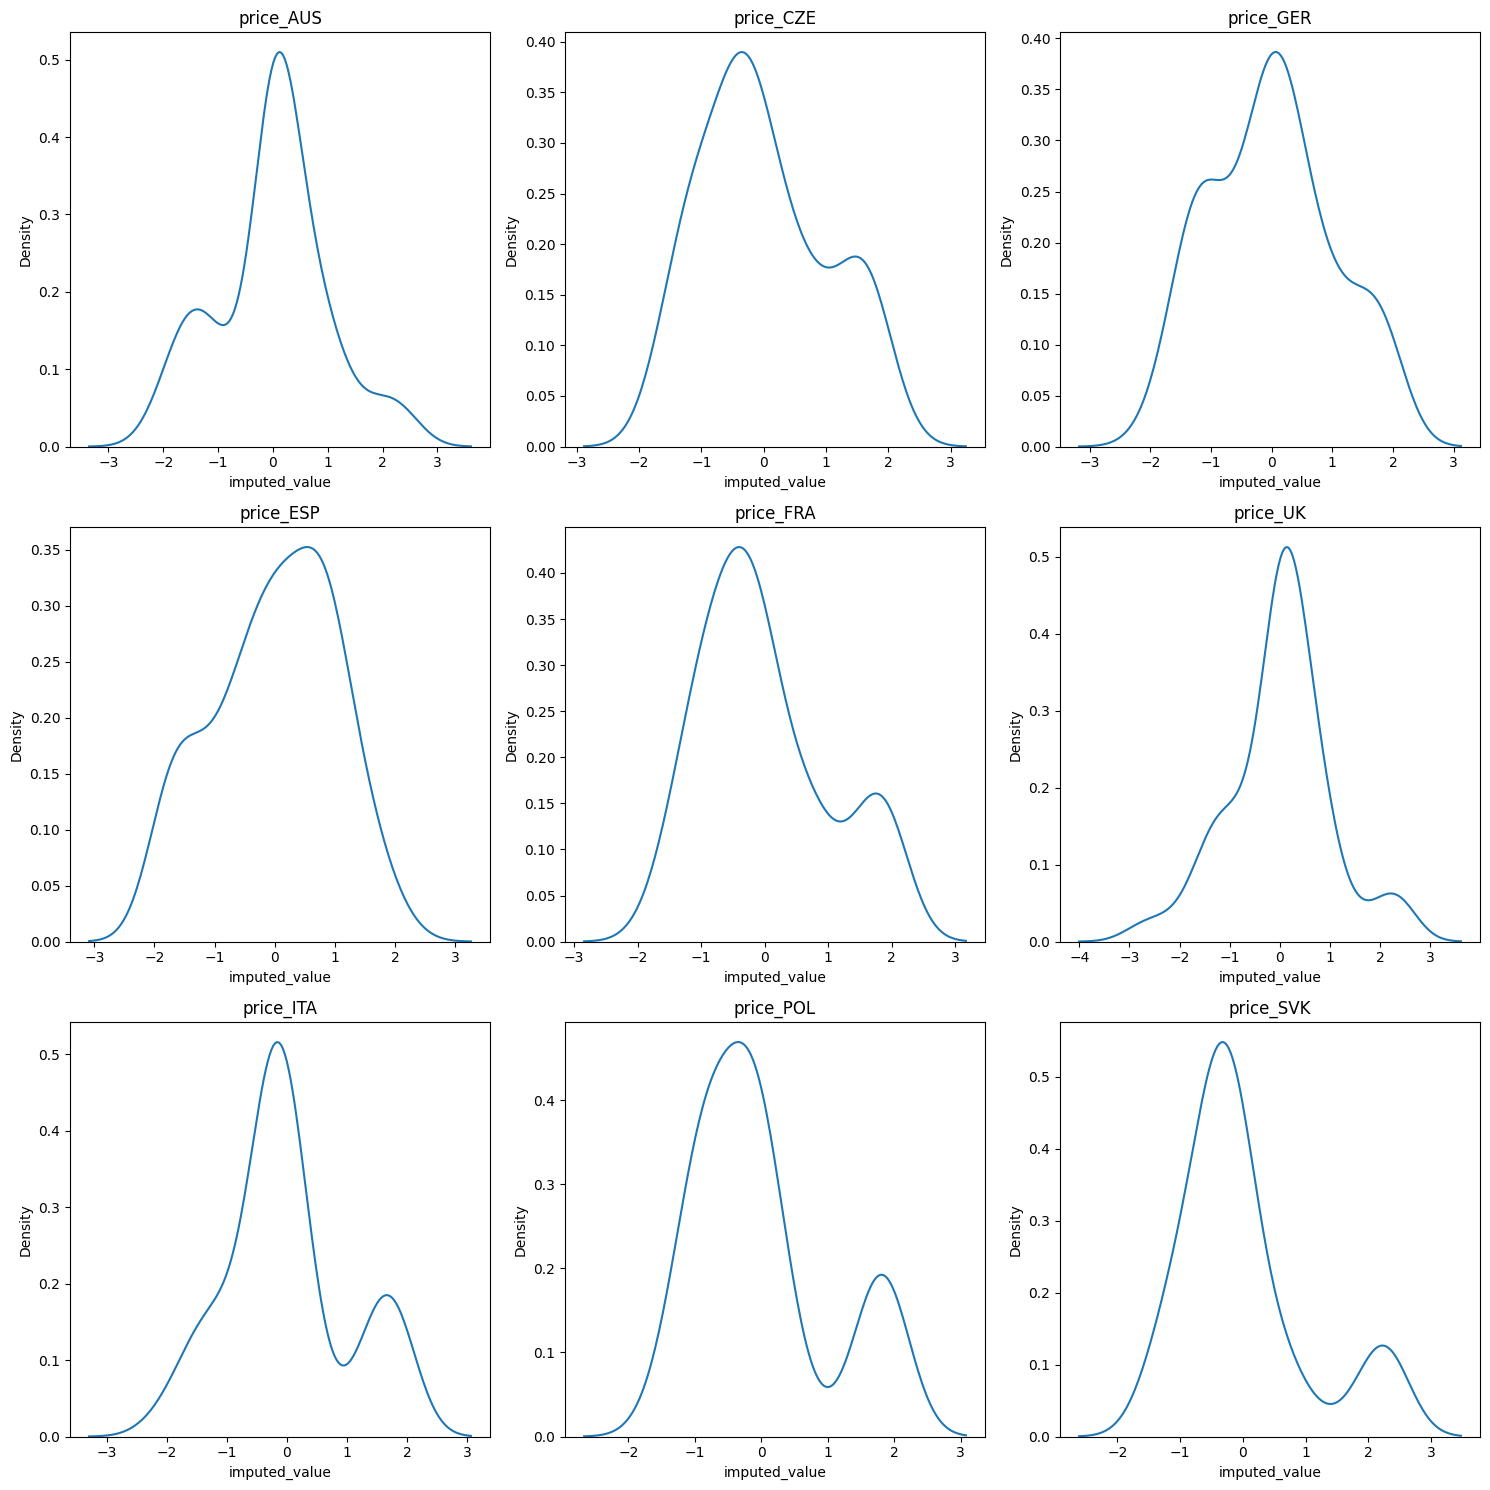

In [89]:
# Now, pre processing the test data
test_df_raw = pd.read_csv("test.csv")

# 1. Impute missing values
test_df_avg_imputed = impute_avg_per_season(test_df_raw)

# 2. Yeo Johnson transformation
test_df_yj = test_df_avg_imputed.copy()
feature_names = [col for col in train_df_boxcox.columns if col not in ['season', 'price_CHF']]
for feature in feature_names:
    test_df_yj[feature], _ = yeojohnson(test_df_yj[feature])

# 3. Scale the data
test_df_normalized = test_df_yj.copy()
test_df_normalized[feature_names] = scaler.fit_transform(test_df_yj[[f'{feature}' for feature in feature_names]])

plot_density_train_df(test_df_normalized, feature_names)

In [90]:
test_df_normalized['price_CHF'] = np.nan
for season, model in best_models.items():
    season_test_data = test_df_normalized[test_df_normalized['season'] == season]
    X_season_test = season_test_data.drop(['price_CHF', 'season'], axis=1)
    test_df_normalized.loc[season_test_data.index, 'price_CHF'] = model.predict(X_season_test)

# Reset the index of the test DataFrame
test_df_normalized = test_df_normalized.reset_index()

# Create a new DataFrame with only the index and predicted price_CHF columns
final_predictions = test_df_normalized[['index', 'price_CHF']]

# Write the final predictions to a CSV file
final_predictions["price_CHF"].to_csv('final.csv')